In [1]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import layers
from keras import regularizers
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/preprocessed_file_v0_filtered', 
                 compression = "zip", header = 0, index_col = 0, sep = "\t")

In [4]:
data = df.drop("CANCER_TYPE", axis = 1)
labels = df["CANCER_TYPE"]

In [5]:
print(labels.unique(), len(labels.unique()))

['Glioma' 'Leukemia' 'Thyroid Cancer' 'Hepatobiliary Cancer'
 'Mature B-Cell Neoplasms' 'Non-Small Cell Lung Cancer'
 'Soft Tissue Sarcoma' 'Pancreatic Cancer' 'Head and Neck Cancer'
 'Esophagogastric Cancer' 'Melanoma' 'Breast Cancer' 'Endometrial Cancer'
 'Colorectal Cancer' 'Prostate Cancer' 'Renal Cell Carcinoma'
 'Bladder Cancer' 'Ovarian Cancer'] 18


In [6]:
encoder = preprocessing.LabelEncoder()
classes = encoder.fit_transform(labels)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
									data, classes, 
									test_size = 0.2, 
									random_state = 0) 

print(y_train.shape)
print(x_train.shape)
print(y_test.shape)
print(x_test.shape)

(78067,)
(78067, 1345)
(19517,)
(19517, 1345)


In [40]:
learning_rate = 0.1
opt = 'ADAM'
lambda_l1 = 0.001
size_batch = 256
nb_epochs = 50

In [39]:
#5th try: change back to l1 and add more neurones in each layer without adding layers

model = Sequential()	
	
model.add(	
	Dense(1028, input_dim = len(data.columns), activation = 'relu',
	      kernel_regularizer = regularizers.l1(lambda_l1)))

model.add(	
	Dense(256, activation = 'relu',
	      kernel_regularizer = regularizers.l1(lambda_l1)))

model.add(	
	Dense(64, activation = 'relu',
	      kernel_regularizer = regularizers.l1(lambda_l1)))
	
model.add(	
	Dense(len(labels.unique()), activation = 'softmax',
	      kernel_regularizer = regularizers.l1(lambda_l1)))
	
model.compile(optimizer = opt,	
						loss = 'sparse_categorical_crossentropy',	
						metrics = ["accuracy"])	

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1028)              1383688   
                                                                 
 dense_17 (Dense)            (None, 256)               263424    
                                                                 
 dense_18 (Dense)            (None, 64)                16448     
                                                                 
 dense_19 (Dense)            (None, 18)                1170      
                                                                 
Total params: 1,664,730
Trainable params: 1,664,730
Non-trainable params: 0
_________________________________________________________________


In [42]:
es = EarlyStopping(
  monitor = 'val_accuracy', mode = 'max', 
	verbose = 1, patience = 30)

In [43]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_d = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [44]:
print(class_weights_d)

{0: 1.6610706838588876, 1: 0.40367233391246793, 2: 0.4585594793355419, 3: 1.467204179822583, 4: 1.585760715011172, 5: 0.7312519904831488, 6: 3.0139371477106014, 7: 2.150250647275932, 8: 1.5472906013398342, 9: 2.040967320261438, 10: 1.1041383797239195, 11: 0.30139371477106014, 12: 1.1937945377251735, 13: 1.09771084676172, 14: 1.255661712668082, 15: 2.73804012345679, 16: 1.4832611339109287, 17: 3.1337106615285806}


In [ ]:
history = model.fit(
	x_train, y_train, 
	validation_data = (x_test, y_test), 
	batch_size = size_batch, 
  epochs = nb_epochs, 
  class_weight = class_weights_d,
	verbose = 1, callbacks = [es])

Epoch 1/50
305/305 [==============================] - 18s 57ms/step - loss: 6.1505 - accuracy: 0.0540 - val_loss: 3.0944 - val_accuracy: 0.0500
Epoch 2/50
305/305 [==============================] - 17s 54ms/step - loss: 3.0943 - accuracy: 0.0544 - val_loss: 3.0931 - val_accuracy: 0.0500
Epoch 3/50
305/305 [==============================] - 16s 54ms/step - loss: 3.0944 - accuracy: 0.0364 - val_loss: 3.0927 - val_accuracy: 0.0500
Epoch 4/50
305/305 [==============================] - 16s 54ms/step - loss: 3.0944 - accuracy: 0.0494 - val_loss: 3.0940 - val_accuracy: 0.1246
Epoch 5/50
305/305 [==============================] - 17s 54ms/step - loss: 3.0944 - accuracy: 0.0497 - val_loss: 3.0921 - val_accuracy: 0.1800
Epoch 6/50
305/305 [==============================] - 16s 54ms/step - loss: 3.0944 - accuracy: 0.0825 - val_loss: 3.0959 - val_accuracy: 0.0503
Epoch 7/50
305/305 [==============================] - 17s 54ms/step - loss: 3.0944 - accuracy: 0.0361 - val_loss: 3.0957 - val_accuracy:

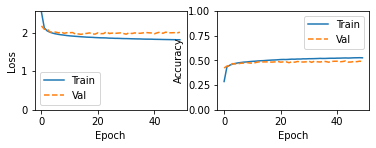

In [38]:
metrics = ['loss', 'accuracy']
for n, metric in enumerate(metrics):
  name = metric.replace("_"," ").capitalize()
  plt.subplot(2,2,n+1)
  plt.plot(history.epoch, history.history[metric],  label='Train')
  plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  if metric == 'loss':
    plt.ylim([0, plt.ylim()[1]])
  elif metric == 'auc':
    plt.ylim([0.8,1])
  else:
    plt.ylim([0,1])

  plt.legend()

